<a href="https://colab.research.google.com/github/KathaSnehitha/Infosys-Internship/blob/main/sql_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# cyber_db_analysis.py

import sqlite3
import pandas as pd
import numpy as np


In [2]:
# -------------------------------
# Step 1: Create Database & Table
# -------------------------------
conn = sqlite3.connect("cybersecurity.db")
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS traffic_logs;")

cursor.execute("""
CREATE TABLE traffic_logs (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    src_ip TEXT,
    dst_ip TEXT,
    protocol TEXT,
    bytes_in INTEGER,
    bytes_out INTEGER,
    duration INTEGER,
    failed_logins INTEGER,
    attack_type TEXT
);
""")

In [3]:
# -------------------------------
# Step 2: Insert Synthetic Data
# -------------------------------
np.random.seed(42)
n_samples = 1000

data = pd.DataFrame({
    "src_ip": np.random.choice(["192.168.1."+str(i) for i in range(1,50)], n_samples),
    "dst_ip": np.random.choice(["10.0.0."+str(i) for i in range(1,50)], n_samples),
    "protocol": np.random.choice(["TCP","UDP","ICMP"], n_samples),
    "bytes_in": np.random.randint(50,5000,n_samples),
    "bytes_out": np.random.randint(50,5000,n_samples),
    "duration": np.random.randint(1,1000,n_samples),
    "failed_logins": np.random.randint(0,5,n_samples),
    "attack_type": np.random.choice(
        ["benign","DDoS","BruteForce","Malware","Phishing"],
        n_samples, p=[0.6,0.15,0.1,0.1,0.05]
    )
})

data.to_sql("traffic_logs", conn, if_exists="append", index=False)

print("Database created with synthetic traffic_logs table.")

Database created with synthetic traffic_logs table.


In [7]:
# -------------------------------
# Step 3: 20 SQL Prompts
# -------------------------------
sql_prompts = [
    # 1. Count rows
    "SELECT COUNT(*) as total_records FROM traffic_logs;",]
for i, query in enumerate(sql_prompts, start=1):
    print(f"\n[SQL Prompt {i}] {query}")
    df = pd.read_sql_query(query, conn)
    print(df.head())


[SQL Prompt 1] SELECT COUNT(*) as total_records FROM traffic_logs;
   total_records
0           1000


In [11]:
#Helper Function to Run Queries
def run_query(query):
    df = pd.read_sql_query(query, conn)
    return df

In [12]:
#Total records
run_query("SELECT COUNT(*) AS total_records FROM traffic_logs;")

,total_records
0,1000


In [13]:
#Attack distribution
run_query("SELECT attack_type, COUNT(*) AS count FROM traffic_logs GROUP BY attack_type;")

,attack_type,count
0,BruteForce,89
1,DDoS,149
2,Malware,105
3,Phishing,44
4,benign,613


In [14]:
#Protocol usage
run_query("SELECT protocol, COUNT(*) AS usage_count FROM traffic_logs GROUP BY protocol;")

,protocol,usage_count
0,ICMP,307
1,TCP,346
2,UDP,347


In [15]:
#Avg duration per attack
run_query("SELECT attack_type, AVG(duration) AS avg_duration FROM traffic_logs GROUP BY attack_type;")

,attack_type,avg_duration
0,BruteForce,507.168539
1,DDoS,497.201342
2,Malware,448.285714
3,Phishing,610.954545
4,benign,519.086460


In [16]:
#Top 5 source IPs
run_query("SELECT src_ip, COUNT(*) AS connections FROM traffic_logs GROUP BY src_ip ORDER BY connections DESC LIMIT 5;")


,src_ip,connections
0,192.168.1.26,30
1,192.168.1.28,29
2,192.168.1.35,28
3,192.168.1.33,28
4,192.168.1.49,27


In [18]:
#Avg bytes in/out per attack
run_query("SELECT attack_type, AVG(bytes_in) AS avg_in, AVG(bytes_out) AS avg_out FROM traffic_logs GROUP BY attack_type;")


,attack_type,avg_in,avg_out
0,BruteForce,2763.258427,2499.730337
1,DDoS,2581.711409,2497.261745
2,Malware,2326.600000,2564.666667
3,Phishing,1996.454545,2784.204545
4,benign,2566.456770,2620.329527


In [20]:
#Total failed logins per attack
run_query("SELECT attack_type, SUM(failed_logins) AS total_failed FROM traffic_logs GROUP BY attack_type;")


,attack_type,total_failed
0,BruteForce,158
1,DDoS,302
2,Malware,228
3,Phishing,79
4,benign,1187


In [21]:
#Max traffic flow
run_query("SELECT src_ip, dst_ip, MAX(bytes_in + bytes_out) AS max_flow FROM traffic_logs;")


,src_ip,dst_ip,max_flow
0,192.168.1.30,10.0.0.40,9680


In [22]:
#Top 5 longest duration connections
run_query("SELECT * FROM traffic_logs ORDER BY duration DESC LIMIT 5;")


,id,src_ip,dst_ip,protocol,bytes_in,bytes_out,duration,failed_logins,attack_type
0,643,192.168.1.40,10.0.0.46,TCP,4164,2996,999,2,benign
1,123,192.168.1.23,10.0.0.3,TCP,2872,2601,998,0,benign
2,486,192.168.1.47,10.0.0.37,TCP,4962,3368,995,4,benign
3,581,192.168.1.37,10.0.0.42,UDP,1560,3769,994,2,benign
4,817,192.168.1.44,10.0.0.6,ICMP,2055,854,992,0,benign


In [23]:
#Attack distribution per protocol
run_query("SELECT protocol, attack_type, COUNT(*) AS count FROM traffic_logs GROUP BY protocol, attack_type;")


,protocol,attack_type,count
0,ICMP,BruteForce,27
1,ICMP,DDoS,41
2,ICMP,Malware,33
3,ICMP,Phishing,17
4,ICMP,benign,189
5,TCP,BruteForce,25
6,TCP,DDoS,49
7,TCP,Malware,42
8,TCP,Phishing,17
9,TCP,benign,213


In [24]:
#High inbound traffic (>4000)
run_query("SELECT * FROM traffic_logs WHERE bytes_in > 4000;")

,id,src_ip,dst_ip,protocol,bytes_in,bytes_out,duration,failed_logins,attack_type
0,1,192.168.1.39,10.0.0.37,TCP,4333,716,474,3,benign
1,3,192.168.1.15,10.0.0.24,ICMP,4693,3793,699,4,benign
2,6,192.168.1.21,10.0.0.2,ICMP,4763,4472,229,2,benign
3,28,192.168.1.44,10.0.0.20,UDP,4050,3749,171,1,DDoS
4,38,192.168.1.3,10.0.0.37,TCP,4009,2830,143,2,DDoS
...,...,...,...,...,...,...,...,...,...
173,971,192.168.1.8,10.0.0.6,ICMP,4332,398,599,0,benign
174,977,192.168.1.41,10.0.0.12,ICMP,4282,4870,527,3,BruteForce
175,982,192.168.1.45,10.0.0.47,TCP,4059,4670,495,1,benign
176,993,192.168.1.11,10.0.0.42,UDP,4494,960,206,1,benign


In [25]:
#Avg failed logins per protocol
run_query("SELECT protocol, AVG(failed_logins) AS avg_failed FROM traffic_logs GROUP BY protocol;")


,protocol,avg_failed
0,ICMP,1.947883
1,TCP,1.985549
2,UDP,1.927954


In [26]:
#Total traffic volume per attack type
run_query("SELECT attack_type, SUM(bytes_in + bytes_out) AS total_traffic FROM traffic_logs GROUP BY attack_type;")

,attack_type,total_traffic
0,BruteForce,468406
1,DDoS,756767
2,Malware,513583
3,Phishing,210349
4,benign,3179500


In [27]:
#Protocol-based duration stats
run_query("SELECT protocol, AVG(duration) AS avg_dur, MAX(duration) AS max_dur FROM traffic_logs GROUP BY protocol;")

,protocol,avg_dur,max_dur
0,ICMP,510.485342,992
1,TCP,511.549133,999
2,UDP,511.982709,994


In [28]:
#Benign ratio
run_query("SELECT (SELECT COUNT(*) FROM traffic_logs WHERE attack_type='benign')*1.0 / COUNT(*) AS benign_ratio FROM traffic_logs;")

,benign_ratio
0,0.613


In [29]:
#IPs with multiple attack types
run_query("SELECT src_ip, COUNT(DISTINCT attack_type) AS attack_variety FROM traffic_logs GROUP BY src_ip HAVING attack_variety > 1;")

,src_ip,attack_variety
0,192.168.1.1,5
1,192.168.1.10,3
2,192.168.1.11,5
3,192.168.1.12,5
4,192.168.1.13,5
5,192.168.1.14,5
6,192.168.1.15,3
7,192.168.1.16,5
8,192.168.1.17,5
9,192.168.1.18,5


In [30]:
#Duration bins
run_query("""
SELECT CASE
    WHEN duration < 100 THEN '<100'
    WHEN duration < 500 THEN '100-500'
    ELSE '500+'
END AS duration_bin, COUNT(*) AS count
FROM traffic_logs GROUP BY duration_bin;
""")

,duration_bin,count
0,100-500,417
1,500+,502
2,<100,81


In [31]:
#High failed logins (≥3)
run_query("SELECT * FROM traffic_logs WHERE failed_logins >= 3;")

,id,src_ip,dst_ip,protocol,bytes_in,bytes_out,duration,failed_logins,attack_type
0,1,192.168.1.39,10.0.0.37,TCP,4333,716,474,3,benign
1,3,192.168.1.15,10.0.0.24,ICMP,4693,3793,699,4,benign
2,5,192.168.1.8,10.0.0.6,ICMP,925,2702,935,3,benign
3,7,192.168.1.39,10.0.0.20,UDP,2511,3874,497,4,benign
4,9,192.168.1.23,10.0.0.11,TCP,1293,1029,473,4,BruteForce
...,...,...,...,...,...,...,...,...,...
376,987,192.168.1.21,10.0.0.4,TCP,3688,2814,795,3,Phishing
377,988,192.168.1.6,10.0.0.6,UDP,2553,386,372,4,Malware
378,994,192.168.1.30,10.0.0.14,ICMP,3997,2046,847,4,benign
379,995,192.168.1.31,10.0.0.11,TCP,1726,3179,43,3,DDoS


In [32]:
#Top 5 suspicious IPs by failed logins
run_query("SELECT src_ip, SUM(failed_logins) AS total_failed FROM traffic_logs GROUP BY src_ip ORDER BY total_failed DESC LIMIT 5;")

,src_ip,total_failed
0,192.168.1.28,65
1,192.168.1.33,63
2,192.168.1.26,59
3,192.168.1.32,56
4,192.168.1.39,55


In [33]:
#KPI Summary
run_query("SELECT AVG(bytes_in) AS avg_in, AVG(bytes_out) AS avg_out, AVG(duration) AS avg_duration FROM traffic_logs;")

,avg_in,avg_out,avg_duration
0,2535.98,2592.625,511.373


<Axes: title={'center': 'Attack Distribution'}, xlabel='attack_type'>

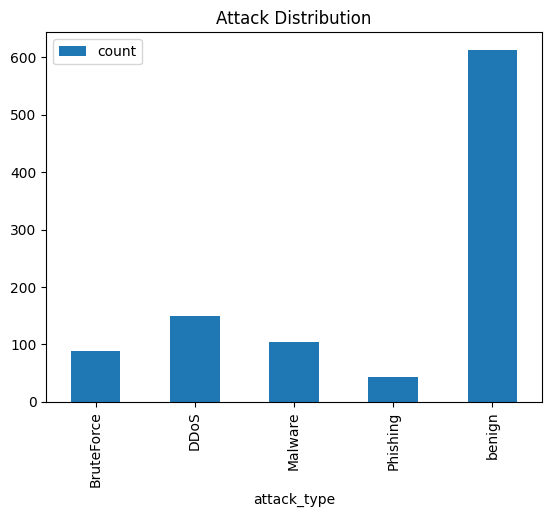

In [34]:
#visualize results
df = run_query("SELECT attack_type, COUNT(*) as count FROM traffic_logs GROUP BY attack_type;")
df.plot(kind="bar", x="attack_type", y="count", title="Attack Distribution")